In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import Sequence, Optional

In [2]:
def plot_dotplot_scanpy(
    adata_list: Sequence[ad.AnnData],
    labels: Sequence[str],
    gene_names: Sequence[str],
    *,
    expression_cutoff: float = 0.1,
    cmap: str = "plasma",
    standard_scale: Optional[str] = "var",  # 'var' (per gene), 'obs' or None
    save_path: Optional[str] = None,
    show: bool = True,
    **dotplot_kwargs,
):
    """
    Build a Scanpy dot-plot from multiple AnnData objects.

    Parameters
    ----------
    adata_list, labels, gene_names
        One AnnData + label per row; genes are columns.
    expression_cutoff
        Minimum expression to count a cell as 'expressing'.
    standard_scale
        'var' = scale each gene (row), 'obs' = each group, None = absolute.
    save_path
        Base path to save .png and .pdf; if None, nothing is saved.
    show
        Whether to render the figure in the current session.
    **dotplot_kwargs
        Forwarded to `sc.pl.dotplot` (e.g. dot_max, mean_only_expressed …).
    """
    # ── Concatenate rows ────────────────────────────────────────────────
    tagged = []
    for a, lbl in zip(adata_list, labels):
        a_cp = a.copy()
        a_cp.obs["__dotplot_group__"] = lbl
        tagged.append(a_cp)
    adata_combined = ad.concat(tagged, join="outer")

   
    adata_combined.obs["__dotplot_group__"] = pd.Categorical(
    adata_combined.obs["__dotplot_group__"],
    categories=list(labels),     # keep the given order
    ordered=True
)
    dp = sc.pl.dotplot(
        adata_combined,
        var_names=gene_names,
        groupby="__dotplot_group__",
        expression_cutoff=expression_cutoff,
        standard_scale=standard_scale,
        color_map=cmap,
        return_fig=True,
        show=False,                # suppress Scanpy auto-display
        **dotplot_kwargs,
    )
    
    # ── Save if requested ──────────────────────────────────────────────
    if save_path:
        dp.savefig(f"{save_path}.png", dpi=500, bbox_inches="tight")
        dp.savefig(f"{save_path}.pdf", dpi=500, bbox_inches="tight")

    return dp

In [3]:
save_dir = '/data/scDisentangle figures/liver_hpi/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
adata_observed = sc.read_h5ad('../../Datasets/preprocessed_datasets/liver.h5ad')
adata_predicted = None
for a_file in tqdm(['pred_ctrl_Pericentral.h5ad', 'pred_ctrl_Periportal.h5ad', 'pred_infected_Pericentral.h5ad',
              'pred_infected_Periportal.h5ad', 'pred_uninfected_Pericentral.h5ad', 
              'pred_uninfected_Periportal.h5ad']):
    _adata_pred = sc.read_h5ad(a_file)
    if adata_predicted is None:
        adata_predicted = _adata_pred.copy()
    else:
        adata_predicted = ad.concat([adata_predicted, _adata_pred])

  0%|                                                                                                                                                                                                                   | 0/6 [00:00<?, ?it/s]/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/ann

In [5]:
adata_predicted.X.max()

7506.1206

# Normalize

In [6]:
#sc.pp.normalize_total(adata_observed)
#sc.pp.normalize_total(adata_predicted)
sc.pp.log1p(adata_observed)
sc.pp.log1p(adata_predicted)

adata.X seems to be already log-transformed.


# Concat

In [7]:
adata_observed.obs['y'] = 'Observed'
adata_predicted.obs['y'] = 'Predicted'
adata_cat = ad.concat([adata_observed, adata_predicted])

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/merge.py:1362: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# UMAP

In [8]:
sc.pp.neighbors(adata_cat)
sc.tl.umap(adata_cat)

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 8203 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
2025-12-14 08:14:28.416147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-14 08:14:28.453678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factor

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


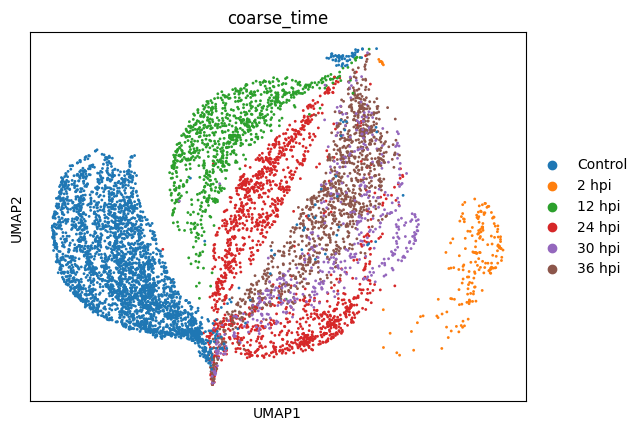

In [9]:
sc.pl.umap(
    adata_cat[(adata_cat.obs['status_control'] != 'Uninfected') & (adata_cat.obs['y'] == 'Observed')],
    color=['coarse_time'],
    show=False
)
plt.savefig(f'{save_dir}infected_ctrl_gt_log.png', dpi=600, bbox_inches='tight')
plt.savefig(f'{save_dir}infected_ctrl_gt_log.pdf', dpi=600, bbox_inches='tight')

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


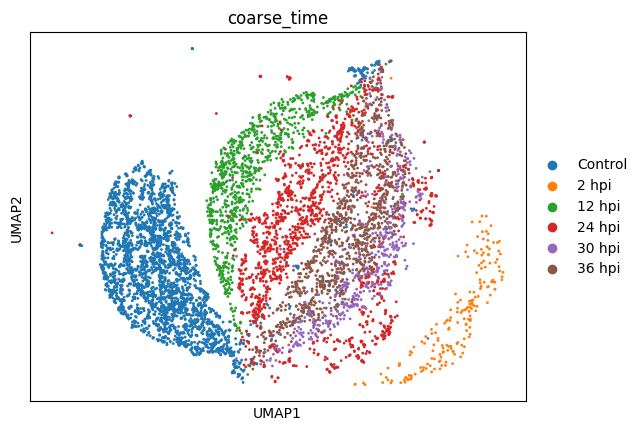

In [10]:
sc.pl.umap(
    adata_cat[(adata_cat.obs['status_control'] != 'Uninfected') & (adata_cat.obs['y'] == 'Predicted')],
    color=['coarse_time'],
    show=False
)
plt.savefig(f'{save_dir}infected_ctrl_pred_log.png', dpi=600, bbox_inches='tight')
plt.savefig(f'{save_dir}infected_ctrl_pred_log.pdf', dpi=600, bbox_inches='tight')